# GReX Technosignature Limits 

$$\text{EIRP}~(f,l,b) = \sigma \times 4 \pi d^2_{\star} \dfrac{A_{e} (f)}{2 T_{\text{sys}}(l,b) \cdot k_b \cdot \delta \nu_t} \sqrt{\dfrac{\delta\nu}{n_p t_\text{obs}}}~\text{W}$$

Calculate, l, b for each of the GReX units throughout the year. Integrate Tsky over the GReX FoV. All this code was modified/inspired by David McKenna. 

In [27]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import optimize as opt
import scienceplots; plt.style.use(['science', 'ieee'])
import pygdsm
from astropy.coordinates import EarthLocation, AltAz, ICRS, SkyCoord
import astropy.units as u
import healpy as hp
from datetime import datetime, timedelta

In [ ]:
RAD2DEG = 180.0 / np.pi
DEG2RAD = np.pi / 180.0

def EIRP(sigma, d_star, A_e_f, T_sys_lb, delta_nu, n_p, t_obs):
    """
    Calculate the EIRP (Equivalent Isotropic Radiated Power).

    Parameters:
    - f: frequency
    - l, b: sky coordinates (Galactic longitude and latitude)
    - sigma: detection threshold (dimensionless)
    - d_star: distance to the star (in meters)
    - A_e_f: effective area as a function of frequency (in m^2)
    - T_sys_lb: system temperature as function of l, b (in K)
    - delta_nu_t: transmission bandwidth (in Hz)
    - delta_nu: resolution bandwidth (in Hz)
    - n_p: number of polarizations
    - t_obs: observation time (in seconds)
    - k_b: Boltzmann constant (default: 1.380649e-23 J/K)

    Returns:
    - EIRP value in watts
    """
    k_b=1.380649e-23
    delta_nu_t = 1 
    
    prefactor = sigma * 4 * np.pi * d_star**2
    denominator = 2 * T_sys_lb * k_b * delta_nu_t
    sqrt_term = np.sqrt(delta_nu / (n_p * t_obs))

    return prefactor * (A_e_f / denominator) * sqrt_term

def gauss2d(sigma, x, y):
    """
    Generate a 2D Gaussian kernel value at (x, y) given standard deviation sigma.
    """
    return np.exp(-(x**2 + y**2) / (2 * sigma**2))


def get_sky_temperature_map(freq_mhz):
    """
    Generate a GSM sky temperature map at the given frequency in MHz.
    Returns:
        coords (SkyCoord): Sky coordinates of map pixels
        temps (ndarray): Temperature values in Kelvin
    """
    gsm = pygdsm.GlobalSkyModel()
    temps = gsm.generate(freq_mhz)  # temps is a 1D array for HEALPix pixels

    nside = hp.get_nside(temps)
    npix = temps.size
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    ra = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    return coords, temps


def convolve_with_beam(coords, temps, pointing_ra, pointing_dec, fwhm=25):
    """
    Convolve the sky temperature map with a fixed Gaussian beam centered at (RA, Dec).
    Args:
        coords (SkyCoord): Sky coordinates of the temperature map
        temps (ndarray): Sky temperatures at those coordinates
        pointing_ra (float): Pointing right ascension in degrees
        pointing_dec (float): Pointing declination in degrees
    Returns:
        convolved_temp (float): Beam-weighted temperature in Kelvin
    """
    beam_center = SkyCoord(ra=pointing_ra*u.deg, dec=pointing_dec*u.deg, frame='icrs')
    sep = coords.separation(beam_center).deg
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    weights = np.exp(-0.5 * (sep / sigma)**2)
    weighted_temp = np.sum(temps * weights)
    norm = np.sum(weights)
    return weighted_temp / norm if norm != 0 else 0.0


### Example Usage 

In [18]:
freq_mhz = 1420
pointing_ra = 180.0  # degrees
pointing_dec = 45.0  # degrees
coords, temps = get_sky_temperature_map(freq_mhz)
t_conv = convolve_with_beam(coords, temps, pointing_ra, pointing_dec, 25)
print(f"Convolved sky temperature at {freq_mhz} MHz: {t_conv:.2f} K")


Convolved sky temperature at 1420 MHz: 0.49 K


## Grabbing RA and DEC for each GReX unit 

In [25]:
def get_zenith(long, lat, time):
    """
    Calculate the zenith angle at a given time and location.
    Args:
        long (float): Longitude in degrees
        lat (float): Latitude in degrees
        time (datetime): Time for which to calculate the zenith angle
    Returns:
        float: ra and dec coordinates in degrees
    """
    location = EarthLocation(lat=lat*u.deg, lon=long*u.deg)
    
    zenith = AltAz(alt=90*u.deg, az=0*u.deg, obstime=time, location=location)
    zenith_icrs = zenith.transform_to(ICRS())

    ra = zenith_icrs.ra; dec = zenith_icrs.dec
    
    return ra.deg, dec.deg

In [26]:
# GReX Station Location 
GReXstations = {
    'HatCreek': (-121.6, 40.8),
    'OVRO': (-118.3, 37.2),
    'Cornell': (-76.5, 42.4),
    'Harvard': (-71.1, 42.4),
    'Birr': (-7.9, 53.1)
}

# Get current Tsys for each station. 
for station, (long, lat) in GReXstations.items():
    current_time = datetime.now()
    
    coords, temps = get_sky_temperature_map(1420)
    ra, dec = get_zenith(long, lat, current_time)
    t_sys = convolve_with_beam(coords, temps, ra, dec)
    
    print(f"Current Tsys for {station}: {t_sys:.2f} K")

Current Tsys for HatCreek: 1.27 K
Current Tsys for OVRO: 1.36 K
Current Tsys for Cornell: 0.73 K
Current Tsys for Harvard: 0.71 K
Current Tsys for Birr: 0.58 K


### Plotting Tsky for 1420 MHz throughout the year for each GReX unit

Station: HatCreek
Station: OVRO
Station: Cornell
Station: Harvard
Station: Birr


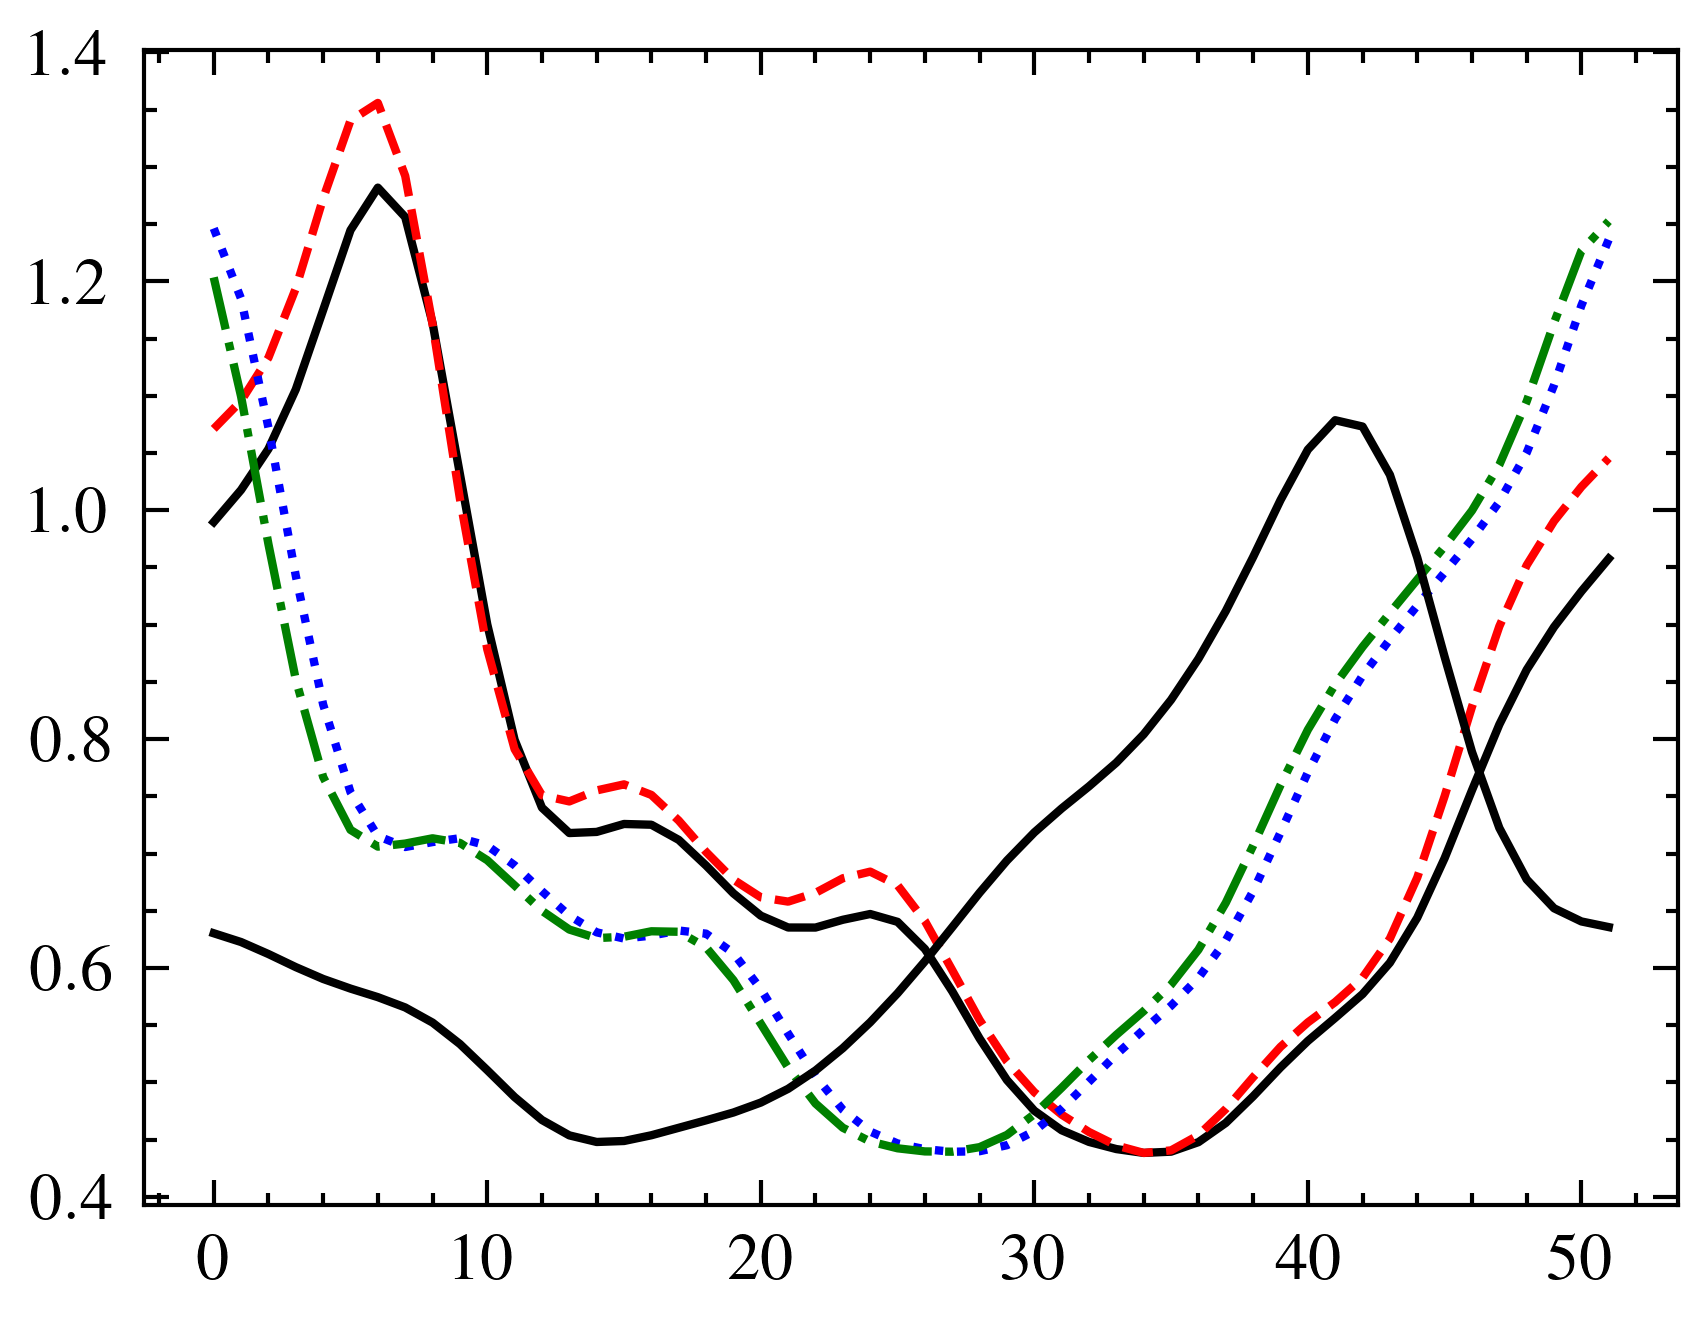

In [28]:
# Measure at midnight every Monday for a year
coords, temps = get_sky_temperature_map(1420)
for station, (long, lat) in GReXstations.items():
    print(f"Station: {station}")
    tsys_arr = []; week_arr = []
    for week in range(52):
        time = datetime(2025, 1, 6) + timedelta(weeks=week)
        ra, dec = get_zenith(long, lat, time)
        t_sys = convolve_with_beam(coords, temps, ra, dec)
        tsys_arr.append(t_sys)
        week_arr.append(week)
    plt.plot(week_arr, tsys_arr, label=station)